# Source Notebook for Airbnb SF Housing Article

In [1]:
import sqlite3

import matplotlib
import numpy
import pandas
import scipy.stats

%matplotlib inline

## Load data

In [2]:
connection = sqlite3.connect('airbnb_zoning.sqlite')

In [3]:
def execute_sql(sql):
    return pandas.read_sql(sql, connection)

## Market Characteristics

**How many listings to be excluded from analysis?**

Number of properties that are hotels or hostels.

In [4]:
execute_sql(
    '''
    SELECT
        SUM(
            CASE
                WHEN
                    (lower(propertyType) like '%hotel%')
                    OR (lower(propertyType) like '%hostel%')
                    OR (roomType = "Hotel room")
                THEN 1.0
                ELSE 0/0
            END
        ) / count(1) AS percentHotels
    FROM
        listings_with_zone
    '''
)

,percentHotels
0,0.079222


Number of properties that are long term rentals

In [5]:
execute_sql(
    '''
    SELECT
        SUM(
            CASE
                WHEN minimumNights + 0.0 > 30 THEN 1.0
                ELSE 0/0
            END
        ) / count(1) AS percentLong
    FROM
        listings_with_zone
    '''
)

,percentLong
0,0.037501


**How many properties per host?**

In [6]:
listings_per_host = execute_sql(
    '''
    SELECT
        hostId,
        count(1) AS cnt
    FROM
        listings_with_zone_filtered
    GROUP BY
        hostId
    ORDER BY
        cnt DESC
    '''
)

In [7]:
total_hosts = execute_sql(
    '''
    SELECT
        count(DISTINCT hostId) AS cnt
    FROM
        listings_with_zone_filtered
    '''
)

In [8]:
listings_per_host['cntCapped'] = listings_per_host['cnt'].apply(lambda x: '5 or More' if x >= 5 else str(x))

In [9]:
listings_per_host_counts = listings_per_host.groupby('cntCapped')['hostId'].count()

In [10]:
total_hosts_cnt = total_hosts.iloc[0]['cnt']

Text(0, 0.5, 'Percent of Hosts')

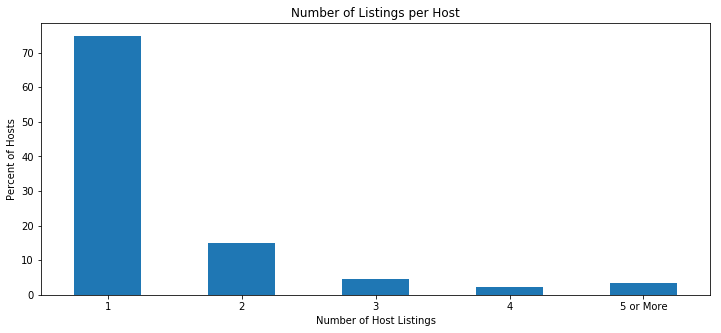

In [11]:
ax = (listings_per_host_counts / total_hosts_cnt * 100).plot.bar(
    title='Number of Listings per Host',
    figsize=(12,5),
    rot=0
)
ax.set_xlabel('Number of Host Listings')
ax.set_ylabel('Percent of Hosts')

Number of hosts with less than 5 listings

In [12]:
listings_per_host[listings_per_host['cnt'] < 5].shape[0] / total_hosts_cnt

0.965121834687052

Number of hosts with 1 listing.

In [13]:
listings_per_host[listings_per_host['cnt'] == 1].shape[0] / total_hosts_cnt

0.7479694218824654

**How much is licensed**

In [14]:
licensed_status = execute_sql(
    '''
    SELECT
        (
            CASE
                WHEN license != "" THEN "yes"
                ELSE "no"
            END
        ) AS isLicensed,
        count(1) AS cnt
    FROM
        listings_with_zone_filtered
    GROUP BY
        isLicensed
    ORDER BY
        cnt DESC
    '''
)

In [15]:
licensed_status['percent'] = licensed_status['cnt'] / licensed_status['cnt'].sum() * 100

Text(0, 0.5, 'License Listed')

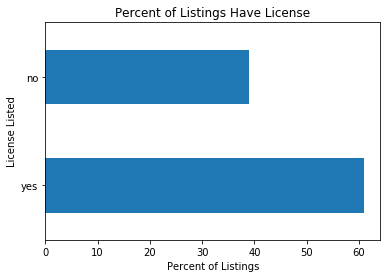

In [16]:
ax = licensed_status.plot.barh(x='isLicensed', y='percent', legend=False, title="Percent of Listings Have License")
ax.set_xlabel("Percent of Listings")
ax.set_ylabel("License Listed")

In [17]:
licensed_status

,isLicensed,cnt,percent
0,yes,4611,61.06476
1,no,2940,38.93524


**Potentially absentee hosts**

In [18]:
absentee = execute_sql(
    '''
    SELECT
        summarized.isLocal AS isLocal,
        count(1) AS cnt
    FROM
        (
            SELECT
                hostId,
                (
                    CASE
                        WHEN hosts_local.isLocalCnt + 0.0 > 0 THEN "yes"
                        ELSE "no"
                    END
                ) AS isLocal
            FROM
                (
                    SELECT
                        sum(
                            CASE
                                WHEN hostLocation like "%San Francisco%" THEN 1
                                WHEN hostLocation like "%California%" THEN 1
                                ELSE 0
                            END
                        ) AS isLocalCnt,
                        hostId
                    FROM
                        listings_with_zone_filtered
                    GROUP BY
                        hostId
                ) hosts_local
        ) summarized
    GROUP BY
        isLocal
    '''
)

In [19]:
absentee['percent'] = absentee['cnt'] / absentee['cnt'].sum() * 100

Text(0, 0.5, 'Percent of Hosts')

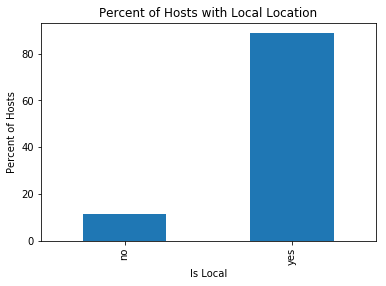

In [20]:
ax = absentee.plot.bar(x='isLocal', y='percent', title='Percent of Hosts with Local Location', legend=None)
ax.set_xlabel('Is Local')
ax.set_ylabel('Percent of Hosts')

In [21]:
absentee

,isLocal,cnt,percent
0,no,474,11.323459
1,yes,3712,88.676541


**Potentially absentee with mulitple listings.**

In [22]:
absentee_detailed = execute_sql(
    '''
    SELECT
        hostId,
        (
            CASE
                WHEN hosts_local.isLocalCnt + 0.0 > 0 THEN "yes"
                ELSE "no"
            END
        ) AS isLocal,
        numListings
    FROM
        (
            SELECT
                sum(
                    CASE
                        WHEN hostLocation like "%San Francisco%" THEN 1
                        WHEN hostLocation like "%California%" THEN 1
                        ELSE 0
                    END
                ) AS isLocalCnt,
                hostId,
                count(1) AS numListings
            FROM
                listings_with_zone_filtered
            GROUP BY
                hostId
        ) hosts_local
    '''
)

In [23]:
absentee_subset_remote = absentee_detailed[absentee_detailed['isLocal'] == 'no']
absentee_subset_local = absentee_detailed[absentee_detailed['isLocal'] == 'yes']

Statistical test if absentee hosts are more likely to hvae >= 3 listings.

In [24]:
contingency = [
    [
        absentee_subset_local[absentee_subset_local['numListings'] >= 3].shape[0],
        absentee_subset_local[absentee_subset_local['numListings'] < 3].shape[0]
    ],
    [
        absentee_subset_remote[absentee_subset_remote['numListings'] >= 3].shape[0],
        absentee_subset_remote[absentee_subset_remote['numListings'] < 3].shape[0]
    ]
]

In [25]:
results = scipy.stats.chi2_contingency(contingency)

In [26]:
p_value = results[1]

if p_value < 0.05:
    msg = 'Finding (p < 0.05)'
else:
    msg = 'No finding (p >= 0.05)'

print(msg)

Finding (p < 0.05)


In [27]:
contingency

[[363, 3349], [69, 405]]

Percent of local hosts have many (>= 3 listings)

In [28]:
contingency[0][0] / (contingency[0][0] + contingency[0][1])

0.09779094827586207

Percent of remote (potentially absentee) hosts have many (>= 3 listings)

In [29]:
contingency[1][0] / (contingency[1][0] + contingency[1][1])

0.14556962025316456

**Absentee landlord network**

Percent of listings by potentially absentee host with many (>= 3) listings

In [30]:
absentee_subset_remote[absentee_subset_remote['numListings'] >= 3]['numListings'].sum() / absentee_detailed['numListings'].sum()

0.11402463249900675

Percent of hosts are potentially absentee host with many (>= 3) listings

In [31]:
absentee_subset_remote[absentee_subset_remote['numListings'] >= 3].shape[0] / absentee_detailed['numListings'].shape[0]

0.016483516483516484

# Zoning / Property Type

**Zoning Info**

In [32]:
zoning_info = execute_sql(
    '''
    SELECT
        zoningSimplified,
        count(1) AS cnt
    FROM
        listings_with_zone_filtered
    GROUP BY
        zoningSimplified
    ORDER BY
        cnt DESC
    '''
)

In [33]:
zoning_info['isHouse'] = zoning_info['zoningSimplified'].apply(lambda x: 'Family House' in x)

Percent in RH-like

In [34]:
zoning_info[zoning_info['isHouse'] == True]['cnt'].sum() / zoning_info['cnt'].sum()

0.4917229506025692

In [35]:
zoning_info['percent'] = zoning_info['cnt'] / zoning_info['cnt'].sum() * 100

Percent of RH in RH1-like

In [36]:
zoning_info[zoning_info['zoningSimplified'] == 'One Family House']['cnt'].sum() / zoning_info[zoning_info['isHouse'] == True]['cnt'].sum()

0.38755723134931325

Text(0, 0.5, '')

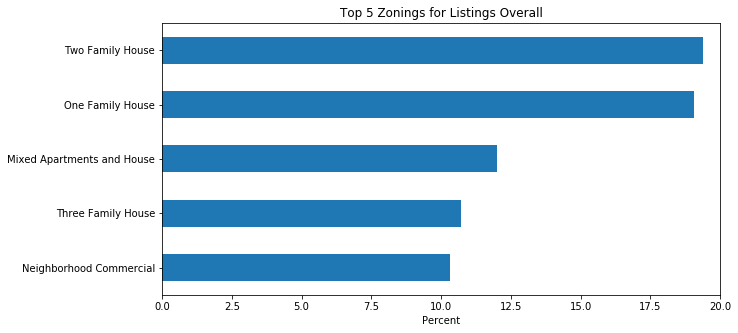

In [37]:
ax = zoning_info.head(5).sort_values('percent').plot.barh(
    title='Top 5 Zonings for Listings Overall',
    x='zoningSimplified',
    y='percent',
    legend=None,
    figsize=(10, 5)
)

ax.set_xlim(0, 20)
ax.set_xlabel('Percent')
ax.set_ylabel('')

In [38]:
zoning_info

,zoningSimplified,cnt,isHouse,percent
0,Two Family House,1463,True,19.374917
1,One Family House,1439,True,19.057079
2,Mixed Apartments and House,907,False,12.011654
3,Three Family House,809,True,10.713813
4,Neighborhood Commercial,779,False,10.316514
5,Public,526,False,6.965965
6,Other Mixed Use,389,False,5.151636
7,Commercial,361,False,4.780824
8,Residential Commercial,320,False,4.237849
9,RTO,280,False,3.708118


**Attribution of Listings**

In [39]:
absentee_listing_data = execute_sql(
    '''
    SELECT
        info_joined.potentialAbsenteeHost AS potentialAbsenteeHost,
        sum(
            CASE
                WHEN isFamilyHouse = 1 THEN 1
                ELSE 0
            END
        ) AS numFamilyHome,
        sum(
            CASE
                WHEN isFamilyHouse = 1 THEN 0
                ELSE 1
            END
        ) AS numOther
    FROM
        (
            SELECT
                family_house_hosts.hostId AS hostId,
                (
                    CASE
                        WHEN host_info.isLocal = 0 AND host_info.numListings >= 3 THEN 1
                        ELSE 0
                    END
                ) AS potentialAbsenteeHost,
                family_house_hosts.isFamilyHouse AS isFamilyHouse
            FROM
                (
                    SELECT
                        hostId,
                        zoningSimplified like "%Family House%" AS isFamilyHouse
                    FROM
                        listings_with_zone_filtered
                ) family_house_hosts
            INNER JOIN
                (
                    SELECT
                        hostId,
                        (
                            CASE
                                WHEN hosts_local.isLocalCnt + 0.0 > 0 THEN 1
                                ELSE 0
                            END
                        ) AS isLocal,
                        numListings
                    FROM
                        (
                            SELECT
                                sum(
                                    CASE
                                        WHEN hostLocation like "%San Francisco%" THEN 1
                                        WHEN hostLocation like "%California%" THEN 1
                                        ELSE 0
                                    END
                                ) AS isLocalCnt,
                                hostId,
                                count(1) AS numListings
                            FROM
                                listings_with_zone_filtered
                            GROUP BY
                                hostId
                        ) hosts_local
                ) host_info
            ON
                host_info.hostId = family_house_hosts.hostId
        ) info_joined
    GROUP BY
        info_joined.potentialAbsenteeHost
    '''
)

In [40]:
results = scipy.stats.chi2_contingency(absentee_listing_data[['numFamilyHome', 'numOther']].to_numpy())

In [41]:
p_value = results[1]

if p_value < 0.05:
    msg = 'Finding (p < 0.05)'
else:
    msg = 'No Finding (p < 0.05)'

In [42]:
print(msg)

Finding (p < 0.05)


In [43]:
absentee_listing_data['percentFamily'] = absentee_listing_data.apply(lambda x: x['numFamilyHome'] / (x['numFamilyHome'] + x['numOther']), axis=1)

Percent of listings in family houses (RH 1-3) by status of if potential absentee host with many listings.

In [46]:
absentee_listing_data

,potentialAbsenteeHost,numFamilyHome,numOther,percentFamily
0,0,3508,3182,0.524365
1,1,205,656,0.238095


In [47]:
absentee_family = absentee_listing_data[absentee_listing_data['potentialAbsenteeHost'] == 1]
non_absentee_family = absentee_listing_data[absentee_listing_data['potentialAbsenteeHost'] == 0]

**Potential Absentee Zones**

In [48]:
zoning_absentee = execute_sql(
    '''
    SELECT
        joined_detailed.zoningSimplified AS zoningSimplified,
        count(1) AS cnt
    FROM
        (
            SELECT
                family_house_hosts.hostId AS hostId,
                (
                    CASE
                        WHEN host_info.isLocal = 0 AND host_info.numListings >= 3 THEN 1
                        ELSE 0
                    END
                ) AS potentialAbsenteeHost,
                family_house_hosts.isFamilyHouse AS isFamilyHouse,
                family_house_hosts.zoningSimplified AS zoningSimplified
            FROM
                (
                    SELECT
                        hostId,
                        zoningSimplified like "%Family House%" AS isFamilyHouse,
                        zoningSimplified
                    FROM
                        listings_with_zone_filtered
                ) family_house_hosts
            INNER JOIN
                (
                    SELECT
                        hostId,
                        (
                            CASE
                                WHEN hosts_local.isLocalCnt + 0.0 > 0 THEN 1
                                ELSE 0
                            END
                        ) AS isLocal,
                        numListings
                    FROM
                        (
                            SELECT
                                sum(
                                    CASE
                                        WHEN hostLocation like "%San Francisco%" THEN 1
                                        WHEN hostLocation like "%California%" THEN 1
                                        ELSE 0
                                    END
                                ) AS isLocalCnt,
                                hostId,
                                count(1) AS numListings
                            FROM
                                listings_with_zone_filtered
                            GROUP BY
                                hostId
                        ) hosts_local
                ) host_info
            ON
                host_info.hostId = family_house_hosts.hostId
        ) joined_detailed
    WHERE
        joined_detailed.potentialAbsenteeHost = 1
    GROUP BY
        zoningSimplified
    ORDER BY
        cnt DESC
    '''
)

In [49]:
zoning_absentee['percent'] = zoning_absentee['cnt'] / zoning_absentee['cnt'].sum() * 100

Text(0, 0.5, '')

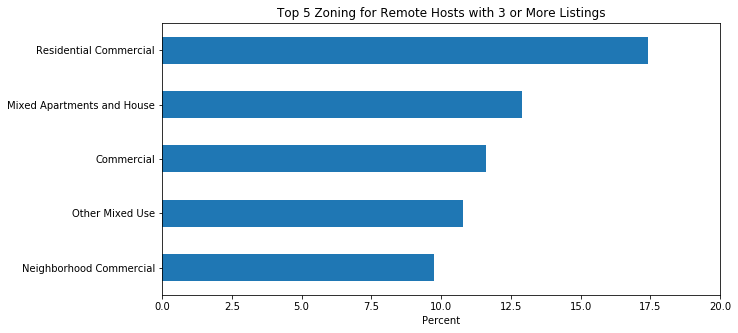

In [50]:
ax = zoning_absentee.head(5).sort_values('percent').plot.barh(
    title='Top 5 Zoning for Remote Hosts with 3 or More Listings',
    x='zoningSimplified',
    y='percent',
    legend=False,
    figsize=(10,5)
)
ax.set_xlim(0, 20)
ax.set_xlabel('Percent')
ax.set_ylabel('')

In [51]:
zoning_local = execute_sql(
    '''
    SELECT
        joined_detailed.zoningSimplified AS zoningSimplified,
        count(1) AS cnt
    FROM
        (
            SELECT
                family_house_hosts.hostId AS hostId,
                (
                    CASE
                        WHEN host_info.isLocal = 1 AND host_info.numListings < 3 THEN 1
                        ELSE 0
                    END
                ) AS potentialLocalHost,
                family_house_hosts.isFamilyHouse AS isFamilyHouse,
                family_house_hosts.zoningSimplified AS zoningSimplified
            FROM
                (
                    SELECT
                        hostId,
                        zoningSimplified like "%Family House%" AS isFamilyHouse,
                        zoningSimplified
                    FROM
                        listings_with_zone_filtered
                ) family_house_hosts
            INNER JOIN
                (
                    SELECT
                        hostId,
                        (
                            CASE
                                WHEN hosts_local.isLocalCnt + 0.0 > 0 THEN 1
                                ELSE 0
                            END
                        ) AS isLocal,
                        numListings
                    FROM
                        (
                            SELECT
                                sum(
                                    CASE
                                        WHEN hostLocation like "%San Francisco%" THEN 1
                                        WHEN hostLocation like "%California%" THEN 1
                                        ELSE 0
                                    END
                                ) AS isLocalCnt,
                                hostId,
                                count(1) AS numListings
                            FROM
                                listings_with_zone_filtered
                            GROUP BY
                                hostId
                        ) hosts_local
                ) host_info
            ON
                host_info.hostId = family_house_hosts.hostId
        ) joined_detailed
    WHERE
        joined_detailed.potentialLocalHost = 1
    GROUP BY
        zoningSimplified
    ORDER BY
        cnt DESC
    '''
)

In [52]:
zoning_local['percent'] = zoning_local['cnt'] / zoning_local['cnt'].sum() * 100

In [53]:
zoning_local.head(5)

,zoningSimplified,cnt,percent
0,Two Family House,959,24.420677
1,One Family House,873,22.230710
2,Three Family House,477,12.146677
3,Mixed Apartments and House,405,10.313216
4,Neighborhood Commercial,360,9.167303
